
# SPRINT CHALLENGE 4 - PREVISÃO DE ACIDENTES COM LSTMs
## Objetivo: Prever o número de acidentes por dia na BR-101

Integrantes do Grupo:
- Matheus Cardoso - RM 564898
- Caique Sousa - RM 563621
- Paulo Gabriel - RM 566446
- Davi Gravina - RM 565619
- William Stahl - RM 562800


# 1. INSTALAÇÃO E IMPORTAÇÃO DE BIBLIOTECAS

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
# TensorFlow e Keras para construção do modelo LSTM
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
# Scikit-learn para pré-processamento e métricas
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

print(f"TensorFlow versão: {tf.__version__}")
print(f"Numpy versão: {np.__version__}")
print(f"Pandas versão: {pd.__version__}")

TensorFlow versão: 2.19.0
Numpy versão: 2.0.2
Pandas versão: 2.2.2


## Explicação:
 - NumPy e Pandas: manipulação de arrays e dataframes
 - Matplotlib e Seaborn: visualização de dados
 - TensorFlow/Keras: framework para construção de redes neurais
 - Scikit-learn: normalização de dados e métricas de avaliação

# 2. CARREGAMENTO DOS DADOS

Vamos fazer upload e carregar os dados de acidentes da PRF

 Certifique-se de ter baixado o arquivo "Agrupados por ocorrência" de 2023 do site da PRF(https://www.gov.br/prf/pt-br/acesso-a-informacao/dados-abertos/dados-abertos-da-prf)

In [4]:
# Upload do arquivo CSV
from google.colab import files
print("Faça upload do arquivo CSV da PRF (Agrupados por ocorrência):")
uploaded = files.upload()

# Pega o nome do arquivo enviado
filename = list(uploaded.keys())[0]

# Carrega o dataset com encoding adequado e separador correto
df = pd.read_csv(filename,
                 encoding='latin1',
                 sep=';',
                 on_bad_lines='skip')

print(f"\n Dados carregados com sucesso!")
print(f" Arquivo: {filename}")
print(f" Shape do dataset: {df.shape}")
print(f" Período dos dados: {df['data_inversa'].min()} a {df['data_inversa'].max()}")
print("\nPrimeiras linhas do dataset:")
print(df.head())


Faça upload do arquivo CSV da PRF (Agrupados por ocorrência):


Saving datatran2023.csv to datatran2023.csv

 Dados carregados com sucesso!
 Arquivo: datatran2023.csv
 Shape do dataset: (67766, 30)
 Período dos dados: 2023-01-01 a 2023-12-31

Primeiras linhas do dataset:
       id data_inversa dia_semana   horario  uf   br     km  \
0  496519   2023-01-01    domingo  02:00:00  ES  101    114   
1  496543   2023-01-01    domingo  03:40:00  SP  116  113,1   
2  496590   2023-01-01    domingo  01:40:00  MT  163   1112   
3  496610   2023-01-01    domingo  10:40:00  PR  376  314,8   
4  496659   2023-01-01    domingo  14:55:00  MG  116  569,4   

           municipio                            causa_acidente  \
0          SOORETAMA            Ausência de reação do condutor   
1            TAUBATE             Entrada inopinada do pedestre   
2  GUARANTA DO NORTE  Reação tardia ou ineficiente do condutor   
3         ORTIGUEIRA                   Velocidade Incompatível   
4           MANHUACU         Acumulo de água sobre o pavimento   

               t

# 3. ANÁLISE EXPLORATÓRIA INICIAL

In [5]:
print("\nInformações gerais do dataset:")
print(df.info())

print("\nColunas disponíveis:")
print(df.columns.tolist())

print("\nEstatísticas descritivas:")
print(df.describe())

print("\nValores ausentes por coluna:")
missing = df.isnull().sum()
print(missing[missing > 0].sort_values(ascending=False))


Informações gerais do dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67766 entries, 0 to 67765
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   id                      67766 non-null  int64 
 1   data_inversa            67766 non-null  object
 2   dia_semana              67766 non-null  object
 3   horario                 67766 non-null  object
 4   uf                      67766 non-null  object
 5   br                      67766 non-null  int64 
 6   km                      67766 non-null  object
 7   municipio               67766 non-null  object
 8   causa_acidente          67766 non-null  object
 9   tipo_acidente           67766 non-null  object
 10  classificacao_acidente  67765 non-null  object
 11  fase_dia                67766 non-null  object
 12  sentido_via             67766 non-null  object
 13  condicao_metereologica  67766 non-null  object
 14  tipo_pista            

### Identificamos a estrutura dos dados, tipos de variáveis e presença de valores nulos.

# 4. FILTRAGEM E SELEÇÃO DE DADOS
 O que vai acontecer: Vamos filtrar os dados para focar em uma rodovia específica

 (BR-101) e selecionar apenas as colunas relevantes para o modelo

In [6]:
# Filtrando para BR-101 (uma das rodovias mais movimentadas)
df_filtered = df[df['br'] == 101].copy()

print(f" Total de acidentes na BR-101: {len(df_filtered)}")
print(f" Período: {df_filtered['data_inversa'].min()} a {df_filtered['data_inversa'].max()}")

# Selecionando colunas relevantes
colunas_relevantes = [
    'data_inversa', 'dia_semana', 'horario', 'uf', 'km',
    'causa_acidente', 'tipo_acidente', 'classificacao_acidente',
    'fase_dia', 'condicao_metereologica', 'tipo_pista',
    'pessoas', 'mortos', 'feridos_leves', 'feridos_graves', 'veiculos'
]

df_filtered = df_filtered[colunas_relevantes].copy()

print(f"\nColunas selecionadas: {len(colunas_relevantes)}")
print(df_filtered.head())


 Total de acidentes na BR-101: 11634
 Período: 2023-01-01 a 2023-12-31

Colunas selecionadas: 16
   data_inversa     dia_semana   horario  uf     km  \
0    2023-01-01        domingo  02:00:00  ES    114   
13   2023-01-02  segunda-feira  07:23:00  SC    134   
16   2023-01-02  segunda-feira  10:15:00  PE     68   
17   2023-01-02  segunda-feira  10:20:00  ES  329,8   
24   2023-01-02  segunda-feira  13:24:00  PE     57   

                              causa_acidente              tipo_acidente  \
0             Ausência de reação do condutor  Saída de leito carroçável   
13  Reação tardia ou ineficiente do condutor           Colisão traseira   
16            Ausência de reação do condutor              Engavetamento   
17               Manobra de mudança de faixa        Colisão transversal   
24  Reação tardia ou ineficiente do condutor           Colisão traseira   

   classificacao_acidente     fase_dia condicao_metereologica tipo_pista  \
0     Com Vítimas Feridas  Plena Noite       

# Explicação:

 Focamos na BR-101 para ter um contexto específico e reduzir a dimensionalidade.

 Selecionamos apenas variáveis que podem influenciar a ocorrência de acidentes.

# 5. ENGENHARIA DE FEATURES TEMPORAIS

Vamos criar features temporais importantes para o modelo LSTM,
incluindo data formatada, dia da semana, mês, hora e contagem de acidentes por dia

In [7]:
# Convertendo data para datetime
df_filtered['data'] = pd.to_datetime(df_filtered['data_inversa'], format='%Y-%m-%d')

# Extraindo componentes temporais
df_filtered['ano'] = df_filtered['data'].dt.year
df_filtered['mes'] = df_filtered['data'].dt.month
df_filtered['dia'] = df_filtered['data'].dt.day
df_filtered['dia_do_ano'] = df_filtered['data'].dt.dayofyear

# Extraindo hora do acidente
df_filtered['hora'] = pd.to_datetime(df_filtered['horario'], format='%H:%M:%S', errors='coerce').dt.hour

# Criando feature cíclica para hora (seno e cosseno)
df_filtered['hora_sin'] = np.sin(2 * np.pi * df_filtered['hora'] / 24)
df_filtered['hora_cos'] = np.cos(2 * np.pi * df_filtered['hora'] / 24)

# Criando feature cíclica para dia da semana
df_filtered['dia_semana_num'] = df_filtered['data'].dt.dayofweek
df_filtered['dia_semana_sin'] = np.sin(2 * np.pi * df_filtered['dia_semana_num'] / 7)
df_filtered['dia_semana_cos'] = np.cos(2 * np.pi * df_filtered['dia_semana_num'] / 7)

# Criando feature cíclica para mês
df_filtered['mes_sin'] = np.sin(2 * np.pi * df_filtered['mes'] / 12)
df_filtered['mes_cos'] = np.cos(2 * np.pi * df_filtered['mes'] / 12)

print("Features temporais criadas:")
print("  - Ano, mês, dia, dia do ano")
print("  - Hora do acidente")
print("  - Features cíclicas (hora, dia da semana, mês)")

# Agregando por dia - TARGET: número de acidentes por dia
df_daily = df_filtered.groupby('data').agg({
    'data_inversa': 'count',  # Contagem de acidentes
    'mortos': 'sum',
    'feridos_leves': 'sum',
    'feridos_graves': 'sum',
    'pessoas': 'sum',
    'veiculos': 'sum',
    'hora_sin': 'mean',
    'hora_cos': 'mean',
    'dia_semana_sin': 'first',
    'dia_semana_cos': 'first',
    'mes_sin': 'first',
    'mes_cos': 'first',
    'dia_do_ano': 'first'
}).reset_index()

df_daily.columns = [
    'data', 'num_acidentes', 'total_mortos', 'total_feridos_leves',
    'total_feridos_graves', 'total_pessoas', 'total_veiculos',
    'hora_media_sin', 'hora_media_cos', 'dia_semana_sin', 'dia_semana_cos',
    'mes_sin', 'mes_cos', 'dia_do_ano'
]

# Ordenando por data
df_daily = df_daily.sort_values('data').reset_index(drop=True)

print(f"\nDataset agregado por dia criado!")
print(f"Shape: {df_daily.shape}")
print(f"Período: {df_daily['data'].min()} a {df_daily['data'].max()}")
print(f"Total de dias com dados: {len(df_daily)}")
print("\nPrimeiras linhas do dataset agregado:")
print(df_daily.head(10))

Features temporais criadas:
  - Ano, mês, dia, dia do ano
  - Hora do acidente
  - Features cíclicas (hora, dia da semana, mês)

Dataset agregado por dia criado!
Shape: (365, 14)
Período: 2023-01-01 00:00:00 a 2023-12-31 00:00:00
Total de dias com dados: 365

Primeiras linhas do dataset agregado:
        data  num_acidentes  total_mortos  total_feridos_leves  \
0 2023-01-01             47             7                   27   
1 2023-01-02             42             0                   47   
2 2023-01-03             34             4                   31   
3 2023-01-04             34             1                   28   
4 2023-01-05             31             0                   25   
5 2023-01-06             22             1                   10   
6 2023-01-07             31             1                   24   
7 2023-01-08             37             1                   42   
8 2023-01-09             37             3                   27   
9 2023-01-10             24             1 

# Explicação:
- Agregamos os dados por dia, contando o número de acidentes e somando vítimas.
- Features cíclicas (seno/cosseno) capturam a natureza periódica do tempo (hora, dia, mês).
- Isso é importante para LSTMs capturarem padrões temporais sazonais.

# 6. VISUALIZAÇÃO DOS DADOS TEMPORAIS

Vamos criar gráficos para visualizar a série temporal
 de acidentes e entender seus padrões

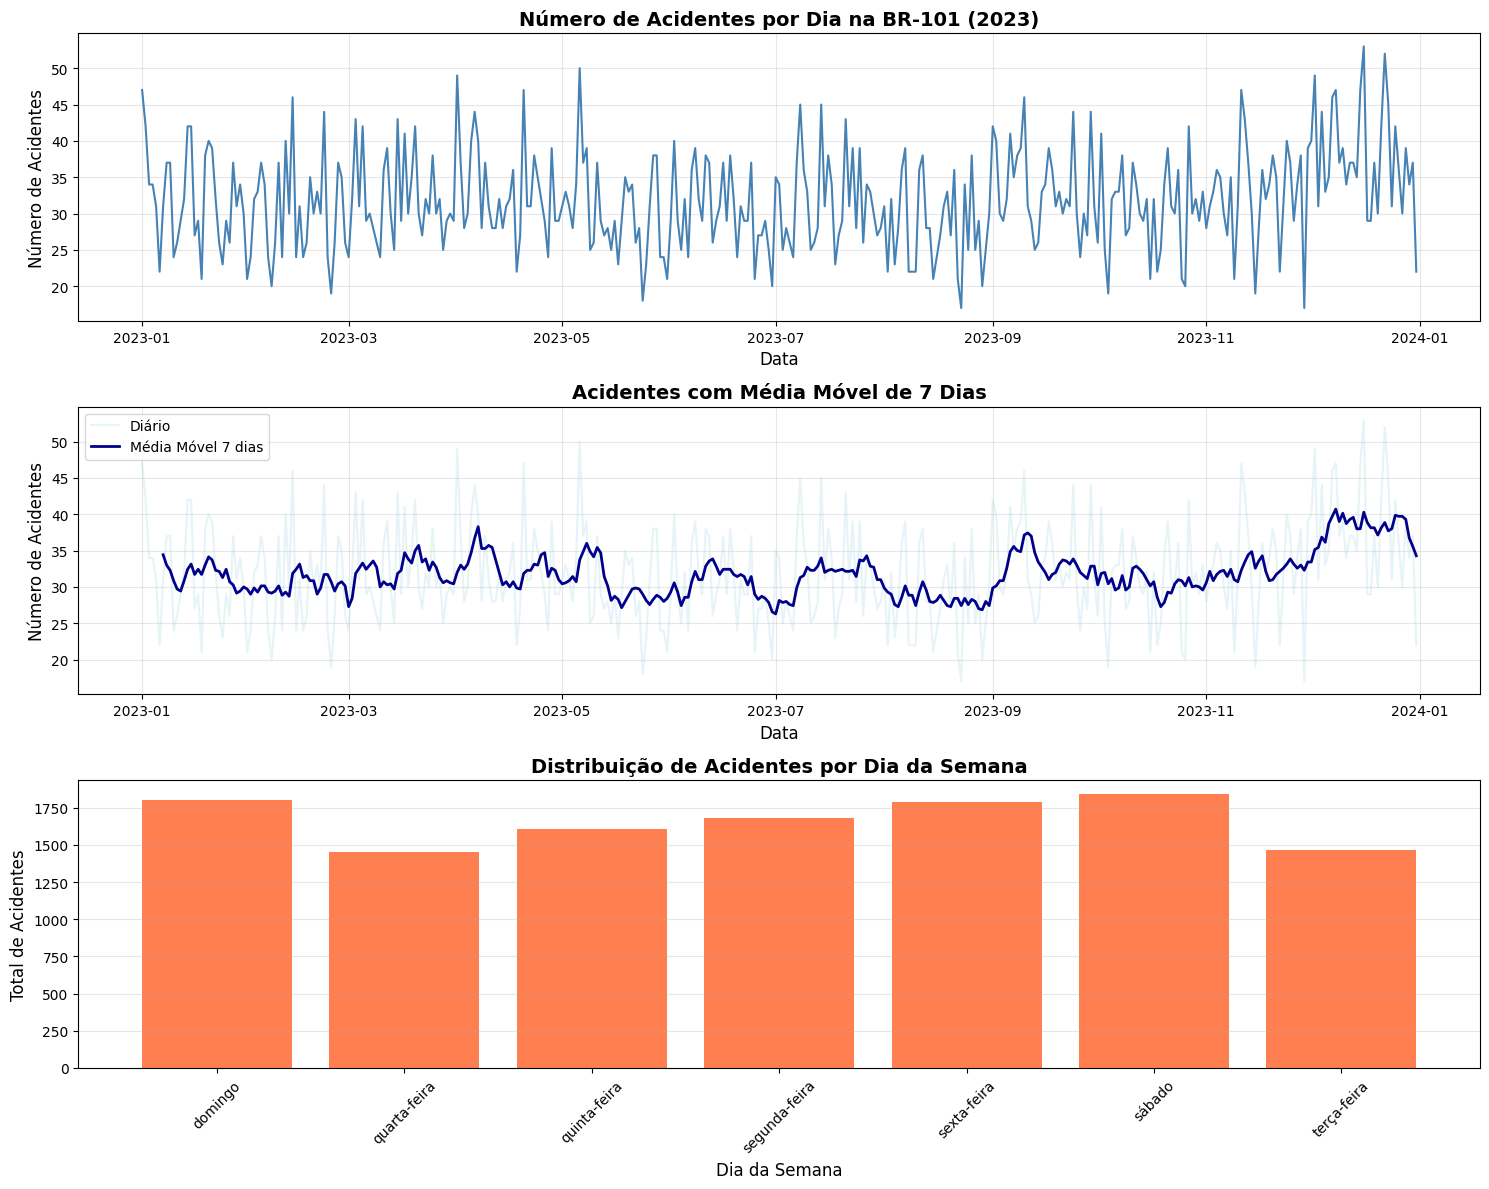

Gráficos gerados com sucesso!

Observações:
  - Média de acidentes por dia: 31.87
  - Desvio padrão: 6.72
  - Mínimo: 17
  - Máximo: 53


In [8]:
fig, axes = plt.subplots(3, 1, figsize=(15, 12))

# Gráfico 1: Número de acidentes por dia
axes[0].plot(df_daily['data'], df_daily['num_acidentes'], linewidth=1.5, color='steelblue')
axes[0].set_title('Número de Acidentes por Dia na BR-101 (2023)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Data', fontsize=12)
axes[0].set_ylabel('Número de Acidentes', fontsize=12)
axes[0].grid(True, alpha=0.3)

# Gráfico 2: Média móvel de 7 dias
df_daily['ma_7'] = df_daily['num_acidentes'].rolling(window=7).mean()
axes[1].plot(df_daily['data'], df_daily['num_acidentes'], alpha=0.3, label='Diário', color='lightblue')
axes[1].plot(df_daily['data'], df_daily['ma_7'], linewidth=2, label='Média Móvel 7 dias', color='darkblue')
axes[1].set_title('Acidentes com Média Móvel de 7 Dias', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Data', fontsize=12)
axes[1].set_ylabel('Número de Acidentes', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Gráfico 3: Distribuição por dia da semana
dia_semana_stats = df_filtered.groupby('dia_semana').size()
axes[2].bar(range(len(dia_semana_stats)), dia_semana_stats.values, color='coral')
axes[2].set_title('Distribuição de Acidentes por Dia da Semana', fontsize=14, fontweight='bold')
axes[2].set_xlabel('Dia da Semana', fontsize=12)
axes[2].set_ylabel('Total de Acidentes', fontsize=12)
axes[2].set_xticks(range(len(dia_semana_stats)))
axes[2].set_xticklabels(dia_semana_stats.index, rotation=45)
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("Gráficos gerados com sucesso!")
print("\nObservações:")
print(f"  - Média de acidentes por dia: {df_daily['num_acidentes'].mean():.2f}")
print(f"  - Desvio padrão: {df_daily['num_acidentes'].std():.2f}")
print(f"  - Mínimo: {df_daily['num_acidentes'].min()}")
print(f"  - Máximo: {df_daily['num_acidentes'].max()}")


# Explicação:
- Visualizamos a série temporal para identificar tendências, sazonalidades e outliers.

- A média móvel suaviza a série e revela padrões subjacentes.

- A distribuição por dia da semana pode revelar padrões semanais (ex: mais acidentes em finais de semana).


# 7. PREPARAÇÃO DOS DADOS PARA LSTM

Vamos criar sequências temporais
 para alimentar o modelo LSTM e normalizar os dados

In [9]:
# Adicionando features de lag (valores passados) - MUITO IMPORTANTE!
print("Criando features de lag...")
df_daily['num_acidentes_lag1'] = df_daily['num_acidentes'].shift(1)
df_daily['num_acidentes_lag2'] = df_daily['num_acidentes'].shift(2)
df_daily['num_acidentes_lag3'] = df_daily['num_acidentes'].shift(3)
df_daily['num_acidentes_lag7'] = df_daily['num_acidentes'].shift(7)

# Adicionando média móvel
df_daily['ma_3'] = df_daily['num_acidentes'].rolling(window=3).mean()
df_daily['ma_7'] = df_daily['num_acidentes'].rolling(window=7).mean()

# Adicionando desvio padrão móvel (volatilidade)
df_daily['std_7'] = df_daily['num_acidentes'].rolling(window=7).std()

# Removendo linhas com NaN criadas pelos lags
df_daily = df_daily.dropna().reset_index(drop=True)

print(f"Features de lag e estatísticas móveis adicionadas")
print(f"Shape após adicionar features: {df_daily.shape}")

# Selecionando features para o modelo (ATUALIZADO COM LAGS)
features = [
    'num_acidentes', 'total_mortos', 'total_feridos_leves', 'total_feridos_graves',
    'total_pessoas', 'total_veiculos', 'hora_media_sin', 'hora_media_cos',
    'dia_semana_sin', 'dia_semana_cos', 'mes_sin', 'mes_cos', 'dia_do_ano',
    'num_acidentes_lag1', 'num_acidentes_lag2', 'num_acidentes_lag3',
    'num_acidentes_lag7', 'ma_3', 'ma_7', 'std_7'
]

df_model = df_daily[features].copy()

print(f"\nFeatures selecionadas: {len(features)}")
print(f"Shape dos dados: {df_model.shape}")

# Removendo valores NaN restantes
df_model = df_model.fillna(method='bfill').fillna(method='ffill')

# Normalizando os dados (LSTM funciona melhor com dados normalizados)
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(df_model)

print(f"\nDados normalizados para o intervalo [0, 1]")

# Criando sequências temporais
# Usaremos os últimos 14 dias para prever o próximo dia
def create_sequences(data, seq_length):
    """
    Cria sequências temporais para LSTM
    Args:
        data: array com os dados normalizados
        seq_length: tamanho da janela temporal
    Returns:
        X: array 3D com as sequências (amostras, timesteps, features)
        y: array 2D com os targets (amostras, features)
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # Prevemos apenas o número de acidentes
    return np.array(X), np.array(y)

SEQ_LENGTH = 14  # Aumentado de 7 para 14 dias

X, y = create_sequences(data_normalized, SEQ_LENGTH)

print(f"\nSequências criadas com sucesso!")
print(f"Shape de X (entrada): {X.shape}")
print(f"  - {X.shape[0]} amostras")
print(f"  - {X.shape[1]} timesteps (dias passados)")
print(f"  - {X.shape[2]} features")
print(f"Shape de y (target): {y.shape}")

# Dividindo em treino, validação e teste (70% / 15% / 15%)
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train = X[:train_size]
y_train = y[:train_size]

X_val = X[train_size:train_size+val_size]
y_val = y[train_size:train_size+val_size]

X_test = X[train_size+val_size:]
y_test = y[train_size+val_size:]

print(f"\nDivisão dos dados:")
print(f"  - Treino: {X_train.shape[0]} amostras ({100*train_size/len(X):.1f}%)")
print(f"  - Validação: {X_val.shape[0]} amostras ({100*val_size/len(X):.1f}%)")
print(f"  - Teste: {X_test.shape[0]} amostras ({100*(len(X)-train_size-val_size)/len(X):.1f}%)")


Criando features de lag...
Features de lag e estatísticas móveis adicionadas
Shape após adicionar features: (358, 21)

Features selecionadas: 20
Shape dos dados: (358, 20)

Dados normalizados para o intervalo [0, 1]

Sequências criadas com sucesso!
Shape de X (entrada): (344, 14, 20)
  - 344 amostras
  - 14 timesteps (dias passados)
  - 20 features
Shape de y (target): (344,)

Divisão dos dados:
  - Treino: 240 amostras (69.8%)
  - Validação: 51 amostras (14.8%)
  - Teste: 53 amostras (15.4%)


# Explicação:
 - Features de lag (lag1, lag2, lag3, lag7): capturam o número de acidentes nos dias anteriores
 - Médias móveis (ma_3, ma_7): suavizam ruídos e revelam tendências
 - Desvio padrão móvel (std_7): captura a volatilidade recente
 - Sequência de 14 dias: captura padrões semanais completos (2 semanas)
 - Divisão cronológica (sem shuffle): essencial para séries temporais
 - Normalização MinMax: coloca todos os valores entre 0 e 1 para melhor convergência

# 8. CONSTRUÇÃO DO MODELO LSTM

Vamos construir uma arquitetura LSTM com múltiplas camadas
 e regularização (Dropout) para evitar overfitting

In [10]:
#Definindo a arquitetura do modelo
model = Sequential([
    # Primeira camada LSTM com 128 unidades
    # return_sequences=True para empilhar outra camada LSTM
    LSTM(128, activation='tanh', return_sequences=True,
         input_shape=(SEQ_LENGTH, X_train.shape[2])),
    Dropout(0.3),  # Dropout de 30% para regularização

    # Segunda camada LSTM com 64 unidades
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.3),

    # Terceira camada LSTM com 32 unidades
    LSTM(32, activation='tanh', return_sequences=False),
    Dropout(0.2),

    # Camadas densas para processamento não-linear
    Dense(32, activation='relu'),
    Dropout(0.2),

    Dense(16, activation='relu'),
    Dropout(0.1),

    # Camada de saída (1 neurônio para regressão)
    Dense(1)
])

# Compilando o modelo com learning rate customizado
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='mean_squared_error',
    metrics=['mae', 'mse']
)

print("Modelo construído com sucesso!")
print("\nArquitetura do modelo MELHORADA:")
model.summary()

print("\n" + "=" * 80)
print("CARACTERÍSTICAS DO MODELO:")
print("=" * 80)
print(f"Total de parâmetros treináveis: {model.count_params():,}")
print(f"Camadas LSTM: 3 (128 → 64 → 32 unidades)")
print(f"Camadas Dense: 2 (32 → 16 unidades)")
print(f"Taxa de Dropout: 10% a 30%")
print(f"Função de ativação LSTM: tanh")
print(f"Função de ativação Dense: relu")
print(f"Optimizer: Adam (lr=0.001)")
print(f"Loss function: Mean Squared Error")

Modelo construído com sucesso!

Arquitetura do modelo MELHORADA:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 14, 128)        │        76,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 14, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 139,713 (545.75 KB)

 Trainable params: 139,713 (545.75 KB)

 Non-trainable params: 0 (0.00 B)


CARACTERÍSTICAS DO MODELO:
Total de parâmetros treináveis: 139,713
Camadas LSTM: 3 (128 → 64 → 32 unidades)
Camadas Dense: 2 (32 → 16 unidades)
Taxa de Dropout: 10% a 30%
Função de ativação LSTM: tanh
Função de ativação Dense: relu
Optimizer: Adam (lr=0.001)
Loss function: Mean Squared Error


# Explicação da arquitetura:
 - 1ª camada LSTM (128 unidades): captura padrões temporais de longo prazo
 - 2ª camada LSTM (64 unidades): refina os padrões capturados
 - 3ª camada LSTM (32 unidades): extrai features de alto nível
 - Dropout (30%, 30%, 20%): regularização forte para evitar overfitting
 - Dense layers (32, 16): processamento não-linear adicional
 - Camada de saída (1 neurônio): predição do número de acidentes
 - Activation 'tanh': geralmente melhor para LSTMs (range -1 a 1)
 - Activation 'relu': boa para camadas densas (range 0 a infinito)
 - Learning rate 0.001: taxa padrão estável para convergência

# 9. TREINAMENTO DO MODELO

Vamos treinar o modelo com callbacks para salvar o melhor
 modelo e parar o treinamento caso não haja melhoria

In [11]:
# Definindo callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=25,  # Para após 25 épocas sem melhoria
    restore_best_weights=True,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    'melhor_modelo_lstm.keras',
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

# Callback para reduzir learning rate quando o treino estagnar
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # Reduz LR pela metade
    patience=10,  # Após 10 épocas sem melhoria
    min_lr=0.00001,  # Learning rate mínimo
    verbose=1
)

print("Callbacks configurados:")
print("EarlyStopping: patience=25")
print("ModelCheckpoint: salva melhor modelo")
print("ReduceLROnPlateau: ajusta learning rate dinamicamente")

# Treinando o modelo
print("\n" + "=" * 80)
print("Iniciando treinamento...")
print("=" * 80)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=200,  # Máximo de 200 épocas
    batch_size=32,  # Processa 32 amostras por vez
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    verbose=1
)

print("\n" + "=" * 80)
print("TREINAMENTO CONCLUÍDO!")
print("=" * 80)
print(f"Total de épocas executadas: {len(history.history['loss'])}")
print(f"Melhor loss de treino: {min(history.history['loss']):.6f}")
print(f"Melhor loss de validação: {min(history.history['val_loss']):.6f}")
print(f"Melhor MAE de treino: {min(history.history['mae']):.6f}")
print(f"Melhor MAE de validação: {min(history.history['val_mae']):.6f}")

# Verificando se houve overfitting
best_train_loss = min(history.history['loss'])
best_val_loss = min(history.history['val_loss'])
gap = best_val_loss - best_train_loss

print(f"\nAnálise de generalização:")
print(f"  - Gap entre treino e validação: {gap:.6f}")
if gap < 0.01:
    print("Excelente generalização!")
elif gap < 0.05:
    print("Boa generalização")
elif gap < 0.1:
    print("Generalização razoável")
else:
    print("Possível overfitting - considere mais regularização")

Callbacks configurados:
EarlyStopping: patience=25
ModelCheckpoint: salva melhor modelo
ReduceLROnPlateau: ajusta learning rate dinamicamente

Iniciando treinamento...
Epoch 1/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.1276 - mae: 0.3025 - mse: 0.1276
Epoch 1: val_loss improved from inf to 0.02598, saving model to melhor_modelo_lstm.keras
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - loss: 0.1196 - mae: 0.2897 - mse: 0.1196 - val_loss: 0.0260 - val_mae: 0.1236 - val_mse: 0.0260 - learning_rate: 0.0010
Epoch 2/200
7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0498 - mae: 0.1819 - mse: 0.0498
Epoch 2: val_loss did not improve from 0.02598
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0495 - mae: 0.1802 - mse: 0.0495 - val_loss: 0.0294 - val_mae: 0.1349 - val_mse: 0.0294 - learning_rate: 0.0010
Epoch 3/200
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0439 - mae: 0.1662 - mse: 0.0439
Epoch 3: val_loss improved from 0.02598 to 0.02527, saving model to melhor_modelo_lstm.keras
8/

# Explicação:
 - Epochs 200: máximo permitido, mas EarlyStopping pode parar antes
 - Batch size 32: bom equilíbrio entre velocidade e estabilidade
 - EarlyStopping (patience=25): para se val_loss não melhorar por 25 épocas
 - ReduceLROnPlateau: reduz learning rate automaticamente quando estagnar
   isso ajuda o modelo a "afinar" o aprendizado e escapar de mínimos locais
 - ModelCheckpoint: salva apenas o melhor modelo baseado em val_loss
 - restore_best_weights=True: garante que usaremos os melhores pesos

# 10. VISUALIZAÇÃO DAS CURVAS DE TREINAMENTO

Vamos plotar as curvas de loss e MAE durante o treinamento
 para verificar se houve overfitting


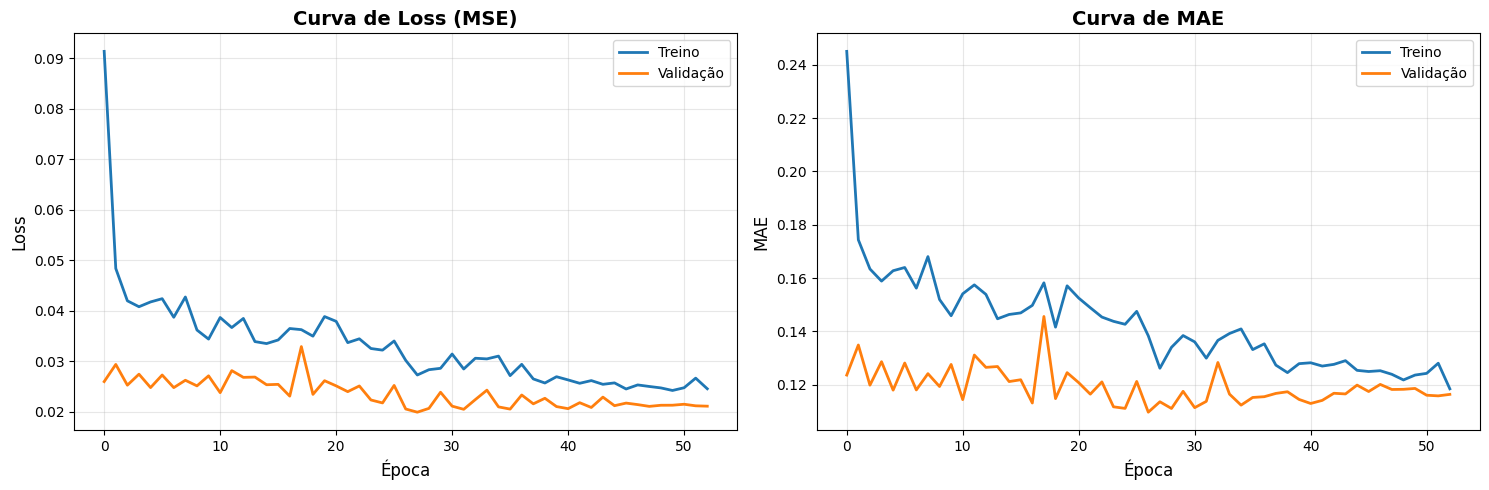

 Curvas de treinamento geradas!

Análise das curvas:
   Possível underfitting - modelo pode ser mais complexo


In [12]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Gráfico de Loss
axes[0].plot(history.history['loss'], label='Treino', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validação', linewidth=2)
axes[0].set_title('Curva de Loss (MSE)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Época', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Gráfico de MAE
axes[1].plot(history.history['mae'], label='Treino', linewidth=2)
axes[1].plot(history.history['val_mae'], label='Validação', linewidth=2)
axes[1].set_title('Curva de MAE', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Época', fontsize=12)
axes[1].set_ylabel('MAE', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(" Curvas de treinamento geradas!")
print("\nAnálise das curvas:")
if min(history.history['val_loss']) < min(history.history['loss']):
    print("   Possível underfitting - modelo pode ser mais complexo")
elif min(history.history['val_loss']) > 1.5 * min(history.history['loss']):
    print("   Possível overfitting - considere mais regularização")
else:
    print("   Modelo apresenta boa generalização")

# Explicação:
- As curvas mostram como o modelo aprendeu ao longo do tempo.
- Se a curva de validação se afastar muito da de treino = overfitting.
- Se ambas ficarem altas = underfitting (modelo muito simples).


# 11. AVALIAÇÃO DO MODELO NO CONJUNTO DE TESTE

Vamos avaliar o modelo no conjunto de teste (dados nunca
 vistos) e calcular métricas de desempenho

 Métricas de Desempenho:
  - MAE (Mean Absolute Error): 6.17 acidentes
  - RMSE (Root Mean Squared Error): 7.63 acidentes
  - R² Score: 0.0479

  Interpretação: Em média, o modelo erra 6.17 acidentes por dia


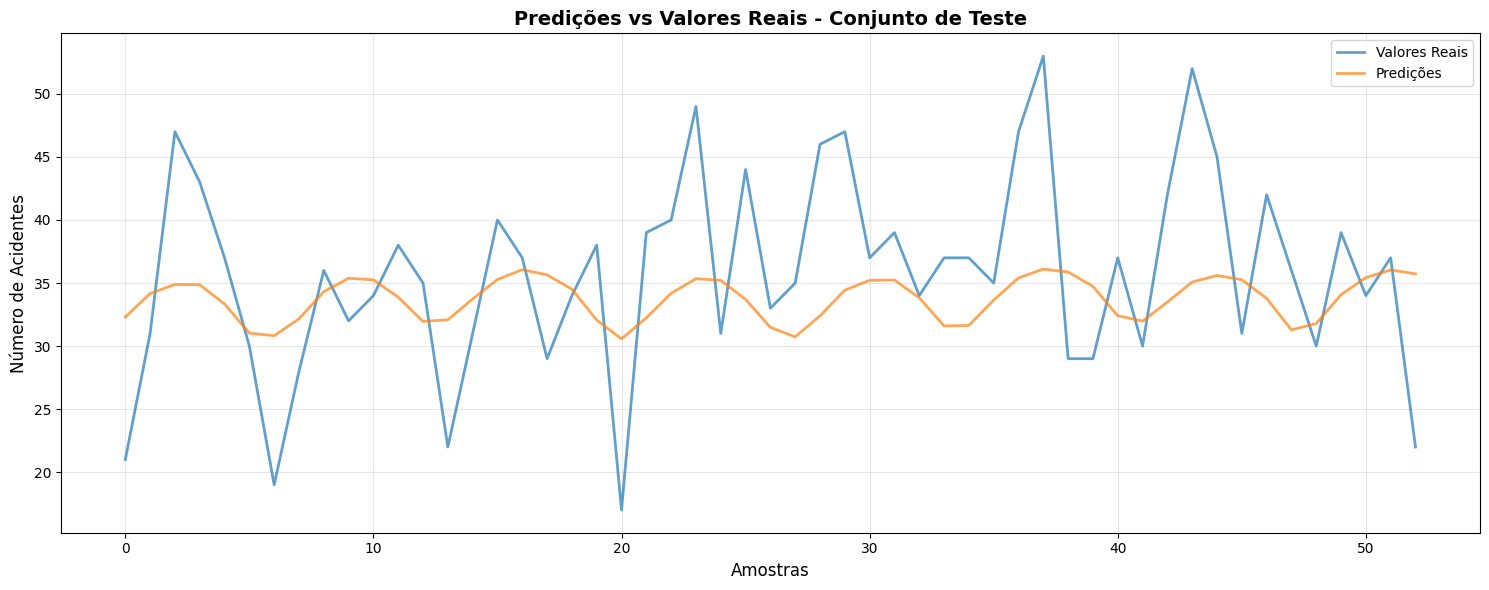

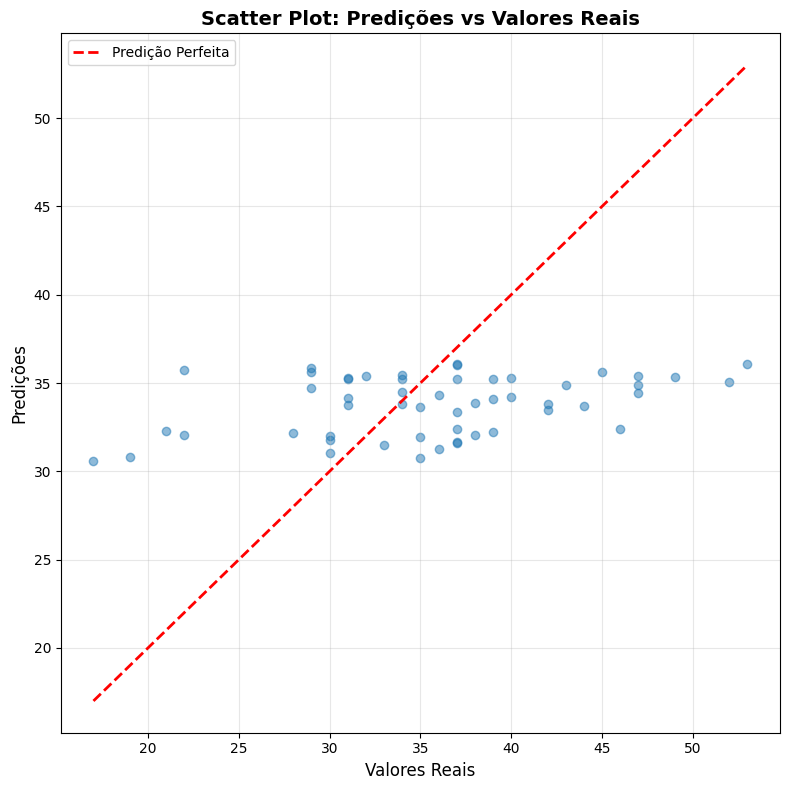


 Gráficos de avaliação gerados!


In [13]:
# Fazendo predições
y_pred = model.predict(X_test, verbose=0)

# Desnormalizando as predições e valores reais
# Criamos um array com zeros e colocamos os valores na primeira coluna
dummy_array = np.zeros((len(y_pred), df_model.shape[1]))
dummy_array[:, 0] = y_pred.flatten()
y_pred_original = scaler.inverse_transform(dummy_array)[:, 0]

dummy_array_test = np.zeros((len(y_test), df_model.shape[1]))
dummy_array_test[:, 0] = y_test
y_test_original = scaler.inverse_transform(dummy_array_test)[:, 0]

# Calculando métricas
mae = mean_absolute_error(y_test_original, y_pred_original)
mse = mean_squared_error(y_test_original, y_pred_original)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_original, y_pred_original)

print(" Métricas de Desempenho:")
print(f"  - MAE (Mean Absolute Error): {mae:.2f} acidentes")
print(f"  - RMSE (Root Mean Squared Error): {rmse:.2f} acidentes")
print(f"  - R² Score: {r2:.4f}")
print(f"\n  Interpretação: Em média, o modelo erra {mae:.2f} acidentes por dia")

# Visualizando predições vs valores reais
plt.figure(figsize=(15, 6))
plt.plot(y_test_original, label='Valores Reais', linewidth=2, alpha=0.7)
plt.plot(y_pred_original, label='Predições', linewidth=2, alpha=0.7)
plt.title('Predições vs Valores Reais - Conjunto de Teste', fontsize=14, fontweight='bold')
plt.xlabel('Amostras', fontsize=12)
plt.ylabel('Número de Acidentes', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Gráfico de dispersão
plt.figure(figsize=(8, 8))
plt.scatter(y_test_original, y_pred_original, alpha=0.5)
plt.plot([y_test_original.min(), y_test_original.max()],
         [y_test_original.min(), y_test_original.max()],
         'r--', linewidth=2, label='Predição Perfeita')
plt.title('Scatter Plot: Predições vs Valores Reais', fontsize=14, fontweight='bold')
plt.xlabel('Valores Reais', fontsize=12)
plt.ylabel('Predições', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\n Gráficos de avaliação gerados!")

# Explicação:
 - MAE: erro médio absoluto em número de acidentes
 - RMSE: penaliza erros grandes mais severamente que MAE
 - R²: proporção da variância explicada (1.0 = perfeito, 0 = ruim)

 O scatter plot mostra se há viés sistemático nas predições.


# 12. SALVANDO O MODELO E RESULTADOS

Vamos salvar o modelo final, o scaler e um resumo dos resultados

In [14]:
# Salvando o modelo final
model.save('modelo_lstm_acidentes_prf.keras')
print("Modelo salvo: modelo_lstm_acidentes_prf.keras")

# Salvando o scaler (necessário para futuras predições)
import pickle
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("Scaler salvo: scaler.pkl")

# Criando resumo dos resultados
resultados = {
    'target': 'Número de acidentes por dia na BR-101',
    'seq_length': SEQ_LENGTH,
    'features': len(features),
    'train_samples': len(X_train),
    'val_samples': len(X_val),
    'test_samples': len(X_test),
    'epochs_trained': len(history.history['loss']),
    'metrics': {
        'MAE': float(mae),
        'RMSE': float(rmse),
        'R2': float(r2)
    }
}

import json
with open('resultados.json', 'w') as f:
    json.dump(resultados, f, indent=4)
print("Resultados salvos: resultados.json")

print("\n" + "=" * 80)
print("PROJETO CONCLUÍDO COM SUCESSO!")
print("=" * 80)
print("\nArquivos gerados:")
print("  1. modelo_lstm_acidentes_prf.keras - Modelo treinado")
print("  2. melhor_modelo_lstm.keras - Melhor modelo durante treinamento")
print("  3. scaler.pkl - Normalizador dos dados")
print("  4. resultados.json - Resumo das métricas")


Modelo salvo: modelo_lstm_acidentes_prf.keras
Scaler salvo: scaler.pkl
Resultados salvos: resultados.json

PROJETO CONCLUÍDO COM SUCESSO!

Arquivos gerados:
  1. modelo_lstm_acidentes_prf.keras - Modelo treinado
  2. melhor_modelo_lstm.keras - Melhor modelo durante treinamento
  3. scaler.pkl - Normalizador dos dados
  4. resultados.json - Resumo das métricas


# Explicação final:
## O modelo está pronto para uso! Para fazer predições futuras:
- 1. Carregue o modelo: model = keras.models.load_model('modelo_lstm_acidentes_prf.keras')
- 2. Carregue o scaler: scaler = pickle.load(open('scaler.pkl', 'rb'))
- 3. Prepare uma sequência de 7 dias de dados normalizados
- 4. Faça a predição: pred = model.predict(sequencia)
- 5. Desnormalize o resultado para obter o número de acidentes previsto

# 13. EXEMPLO DE USO DO MODELO PARA PREDIÇÃO

Vamos demonstrar como usar o modelo salvo para fazer
 uma predição de acidentes para o próximo dia

In [15]:
# Pegando os últimos 7 dias do conjunto de teste para fazer uma predição exemplo
ultima_sequencia = X_test[-1].reshape(1, SEQ_LENGTH, X_train.shape[2])

# Fazendo a predição
predicao = model.predict(ultima_sequencia, verbose=0)

# Desnormalizando
dummy = np.zeros((1, df_model.shape[1]))
dummy[:, 0] = predicao.flatten()
predicao_original = scaler.inverse_transform(dummy)[:, 0]

print(f"Predição para o próximo dia:")
print(f"  - Número estimado de acidentes: {predicao_original[0]:.2f}")
print(f"  - Número real de acidentes: {y_test_original[-1]:.2f}")
print(f"  - Erro absoluto: {abs(predicao_original[0] - y_test_original[-1]):.2f}")

Predição para o próximo dia:
  - Número estimado de acidentes: 35.73
  - Número real de acidentes: 22.00
  - Erro absoluto: 13.73
